# Airline Sentiment Analysis
*Dataset and notebook reference: https://www.kaggle.com/code/chibuzorokocha/airline-sentiment-analysis-90-accuracy-using-rnn/notebook* </br>
*Disclaimer: Most of the changes in my version are in the model itself*
## Importing necessary libraries

In [1]:
import re
import warnings
import itertools
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore", category=FutureWarning)

2024-11-24 22:24:31.862445: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 22:24:31.865275: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 22:24:31.872639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 22:24:31.884919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 22:24:31.888313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:24:31.898214: I tensorflow/core/platform/cpu_feature_gu

## Reading the dataset

In [2]:
data = pd.read_csv("./dataset/Tweets.csv")
df = data[["text","airline_sentiment"]]
df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))

/tmp/ipykernel_35086/3063916321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


In [3]:
df.head()

,text,airline_sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative


/tmp/ipykernel_35086/415373964.py:3: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data.airline, palette=color_palette);


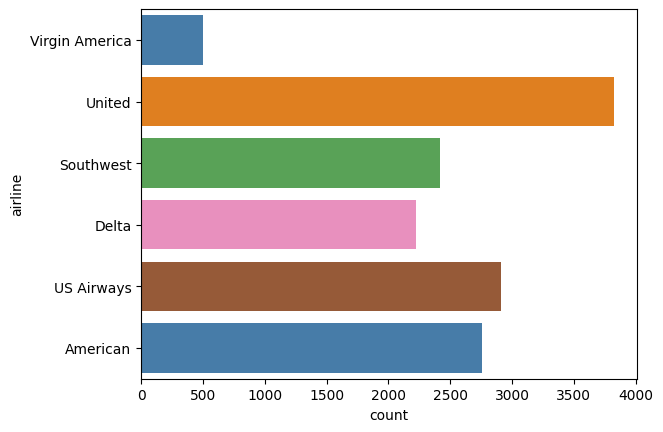

In [4]:
# Color-blind friendly color palette
color_palette = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628']
sns.countplot(data.airline, palette=color_palette);

In [5]:
df = df[df.airline_sentiment!="neutral"] # Removing neutral responses
df['text'] = df['text'].apply(lambda x: x.lower()) # Doing some text preprocessing
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # Keeping numbers and strings only

In [6]:
df.head(5) #Quick Look 

,text,airline_sentiment
1,plus youve added commercials to the experienc...,positive
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative
5,seriously would pay 30 a flight for seats tha...,negative
6,yes nearly every time i fly vx this ear worm ...,positive


/tmp/ipykernel_35086/1255433316.py:1: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(df.airline_sentiment, palette=color_palette); # Mostly Negative Reviews are present (Class Imbalance found)


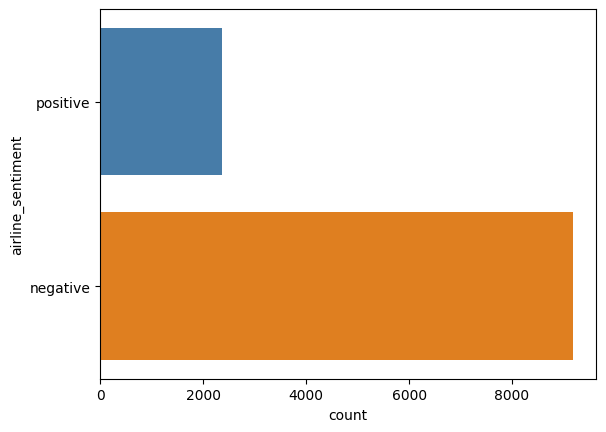

In [7]:
sns.countplot(df.airline_sentiment, palette=color_palette); # Mostly Negative Reviews are present (Class Imbalance found) 

In [8]:
df = df.drop(df[df.airline_sentiment == "negative"].iloc[:5000].index)

/tmp/ipykernel_35086/2003741473.py:1: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(df.airline_sentiment, palette=color_palette);


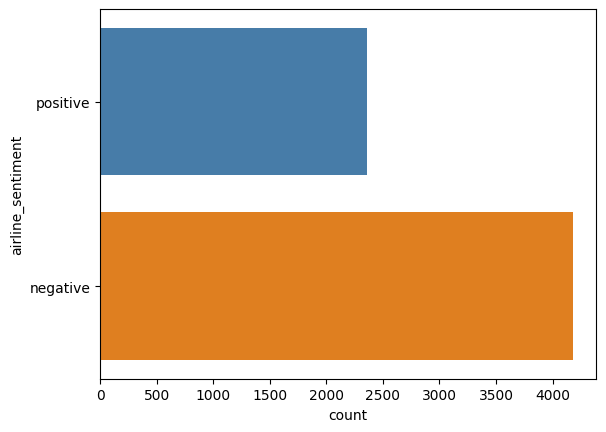

In [9]:
sns.countplot(df.airline_sentiment, palette=color_palette);

In [10]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tckleme/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to calculate compound sentiment score
def get_vader_sentiment(sentence):
    return analyzer.polarity_scores(sentence)['compound']

# Add VADER scores to the dataframe
df['vader_score'] = df['text'].apply(get_vader_sentiment)

In [12]:
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)

# Preparing labels
Y = df['airline_sentiment']
L = Y.map({'negative': 0, 'positive': 1}).values

## Using Vader & Converting text to sequences and padding them

In [13]:
# Tokenize and pad text data
X_text = tokenizer.texts_to_sequences(df['text'].values)
X_text = pad_sequences(X_text)

# Combine padded sequences with VADER scores
X_vader = df['vader_score'].values.reshape(-1, 1)
X_combined = np.hstack((X_text, X_vader))  # Combining padded sequences with VADER scores

## Train test split

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_combined, L,
    test_size=0.3,
    shuffle=True,
    stratify=L,
    random_state=1
)

## Defining the model

In [15]:
embed_dim = 128
lstm_out = 196

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_features, embed_dim, input_length=X_train.shape[1] - 1))  # Exclude VADER score
model.add(tf.keras.layers.SpatialDropout1D(0.5))
model.add(tf.keras.layers.LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/home/tckleme/Documents/Projects/envs/bcc/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1732466375.016519   35086 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 22:24:35.016959: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6541 entries, 1 to 14638
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               6541 non-null   object 
 1   airline_sentiment  6541 non-null   object 
 2   vader_score        6541 non-null   float64
dtypes: float64(1), object(2)
memory usage: 204.4+ KB


## Training the model

In [17]:
Model = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

Epoch 1/20
115/115 - 3s - 30ms/step - accuracy: 0.7411 - loss: 0.5110 - val_accuracy: 0.8461 - val_loss: 0.3528
Epoch 2/20
115/115 - 2s - 15ms/step - accuracy: 0.8946 - loss: 0.2689 - val_accuracy: 0.8832 - val_loss: 0.2677
Epoch 3/20
115/115 - 2s - 15ms/step - accuracy: 0.9287 - loss: 0.1953 - val_accuracy: 0.9105 - val_loss: 0.2267
Epoch 4/20
115/115 - 2s - 16ms/step - accuracy: 0.9579 - loss: 0.1212 - val_accuracy: 0.8974 - val_loss: 0.2706
Epoch 5/20
115/115 - 2s - 16ms/step - accuracy: 0.9659 - loss: 0.1105 - val_accuracy: 0.9061 - val_loss: 0.2817
Epoch 6/20
115/115 - 2s - 16ms/step - accuracy: 0.9727 - loss: 0.0802 - val_accuracy: 0.9105 - val_loss: 0.3496
Epoch 7/20
115/115 - 2s - 15ms/step - accuracy: 0.9752 - loss: 0.0721 - val_accuracy: 0.9061 - val_loss: 0.2727
Epoch 8/20
115/115 - 2s - 18ms/step - accuracy: 0.9773 - loss: 0.0630 - val_accuracy: 0.8985 - val_loss: 0.3908
Epoch 9/20
115/115 - 2s - 17ms/step - accuracy: 0.9880 - loss: 0.0400 - val_accuracy: 0.9061 - val_loss:

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 128)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 32, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 196)            │       254,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        19,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,360,108 (9.00 MB)

 Trainable params: 786,702 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,573,406 (6.00 MB)

## Making predictions

In [19]:
nn_prediction = model.predict(X_test)

# Getting the class with the highest probability
nn_labels = np.argmax(nn_prediction, axis=1)

# Using VADER as a fallback for ambiguous predictions
for i, text in enumerate(df['text'][len(Y_train):]):  # Test set
    vader_score = get_vader_sentiment(text)
    if abs(vader_score) > 0.5:  # ONLY If VADER is confident
        print(f"Sentence: {text}")
        print(f"Neural Network Prediction: {nn_labels[i]}")
        print(f"VADER Sentiment Score: {vader_score}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Sentence:  if the flight i selected online was what was ticketed i would not be missing my connection i need help getting to dfw or iah
Neural Network Prediction: 1
VADER Sentiment Score: 0.5556
Sentence:  my seat is disgusting old and dirty when are you going to refurbish this plane  us air 597 jfk to phx
Neural Network Prediction: 0
VADER Sentiment Score: -0.743
Sentence:  i understand the need to drain the lavatory fearing freezing but why no policy on checking that before boarding smh come on
Neural Network Prediction: 0
VADER Sentiment Score: -0.8074
Sentence:  no repair made to the water line no potable water on board this flight we will take off soon time for new planes mcigtdfw
Neural Network Prediction: 1
VADER Sentiment Score: -0.5267
Sentence:  there is no local agent there is no person to answer our questions and their phone service is terrible
Neural Network Prediction: 1
VADER Sentiment Score: -0.7579
Sentence:  living in dfw your hu

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


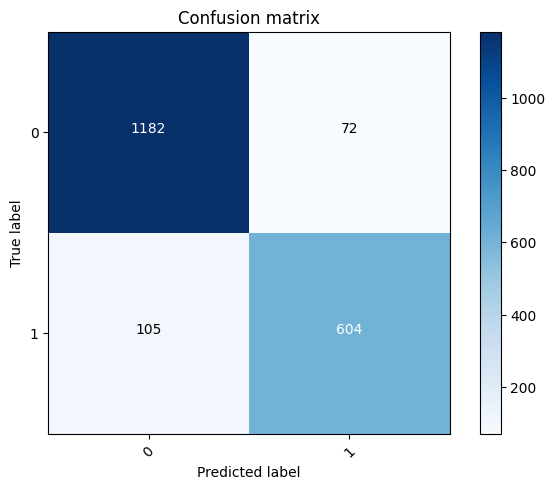

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
confusion_mtx = confusion_matrix(Y_test, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

## Evaluating the model

In [23]:
test_sentence = "The air crew is bad"
vader_score = get_vader_sentiment(test_sentence)
print(f"VADER Sentiment Score: {vader_score}")

# Preprocessing test_sentence for the model
test_sequence = tokenizer.texts_to_sequences([test_sentence])
test_sequence = pad_sequences(test_sequence, maxlen=X_train.shape[1] - 1)  # Matching model input length
test_combined = np.hstack((test_sequence, [[vader_score]]))  # Combining with VADER score

# Model prediction
model_prediction = model.predict(test_combined)
print(f"Neural Network Prediction: {np.argmax(model_prediction, axis=1)}")

VADER Sentiment Score: -0.5423
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Neural Network Prediction: [0]


*0 -> Negative* </br>
*1 -> Positive*